In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_2011 = '2011-01-01T00:00:00.000Z'
jan1_2011 = astropy.time.Time(jan1_2011).jd
print(jan1_2011)

2450083.5
2455562.5


In [3]:
dayspermonth = [31,28,31,30,31,30,31,31,30,31,30,31,0]
months = [r'Jan',r'Feb',r'Mar',r'Apr',r'May',r'June',r'July',r'Aug',r'Sept',r'Oct',r'Nov',r'Dec','']
# all years divisible by 4 during SOHO are leap years, including 2000

# load EIT

In [4]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results = np.genfromtxt("./EIT/EITresults/EIT_LC_withflags.txt")
print(np.shape(results))

(2463, 3)
(91883, 7)


In [5]:
metadata = Table.read("./EIT/EITresults/EIT_headerMetadata.txt",format="ascii")
print(metadata.colnames)

['DATE-BEG', 'DATE-AVG', 'XPOSURE', 'CMDXPOS', 'SHUTCLS', 'FILTER', 'WAVELNTH', 'OBJECT', 'SCI_OBJ', 'OBS_PROG', 'CMP_NO', 'UCD', 'EXPMODE', 'LYNESYNC', 'ROUTPORT', 'NLEBPROC', 'LEBPROC1', 'LEBPROC2', 'LEBPROC3', 'WCSNAME', 'CTYPE1', 'CTYPE2', 'CUNIT1', 'CUNIT2', 'PC1_1', 'PC1_2', 'PC2_1', 'PC2_2', 'CDELT1', 'CDELT2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CROTA', 'CFTEMP', 'CCDTEMP', 'SOLAR_B0', 'RSUN_ARC', 'RSUN_OBS', 'RSUN_REF', 'CAR_ROT', 'DSUN_OBS', 'SC_X0', 'SC_Y0', 'SC_ROLL', 'HAEX_OBS', 'HAEY_OBS', 'HAEZ_OBS']


In [6]:
medDist = np.median(results[:,1])*u.m
print(medDist)
print(medDist.to(u.AU))

AUinm = (u.AU.to(u.m))
print(AUinm)

148114320263.0 m
0.9900830778535941 AU
149597870700.0


In [7]:
# restrict to after commissioning was completed on Apr 16, 1996
postCommissioningMask = (results[:,0] >= 2450190.)
results = results[postCommissioningMask]
metadata = metadata[postCommissioningMask]

ts = results[:,0]                               # average date of observation
dists = results[:,1]                            # heliocentric distance in meters
ws = results[:,2].astype(float)                 # wavelength of observation
fs = results[:,3] * (dists/AUinm)               # normalize flux to heliocentric distance of 1AU
us = results[:,4] * (dists/AUinm)               # normalize flux uncertainty to heliocentric distance of 1AU
ps = results[:,5]                               # pinhole flag (==1 if Yes; can only ==1 if the Al_+1 filter was not used)
ces = results[:,6]                              # cameraError flag (==1 if Yes; still not clear exactly what this means)

m171 = (ws == 171.) 
m195 = (ws == 195.) 
m284 = (ws == 284.) 
m304 = (ws == 304.) 
wmasks = [m304,m284,m195,m171]

noPinholes = (ps == 0)
noCameraErrors = (ces == 0)


In [8]:
print("171")
print(np.shape(fs[m171]))
print(np.shape(fs[m171 & noPinholes])[0]/np.shape(fs[m171])[0])
print(np.shape(fs[m171 & noPinholes & noCameraErrors])[0]/np.shape(fs[m171])[0])

print("195")
print(np.shape(fs[m195]))
print(np.shape(fs[m195 & noPinholes])[0]/np.shape(fs[m195])[0])
print(np.shape(fs[m195 & noPinholes & noCameraErrors])[0]/np.shape(fs[m195])[0])

print("284")
print(np.shape(fs[m284]))
print(np.shape(fs[m284 & noPinholes])[0]/np.shape(fs[m284])[0])
print(np.shape(fs[m284 & noPinholes & noCameraErrors])[0]/np.shape(fs[m284])[0])

print("304")
print(np.shape(fs[m304]))
print(np.shape(fs[m304 & noPinholes])[0]/np.shape(fs[m304])[0])
print(np.shape(fs[m304 & noPinholes & noCameraErrors])[0]/np.shape(fs[m304])[0])

171
(22574,)
0.9997342074953486
0.5036324975635688
195
(23354,)
0.9996146270446177
0.5073649053695298
284
(22673,)
0.9437216071979888
0.4665902174392449
304
(22645,)
0.9992492824022963
0.4949436961801722


In [9]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
heaterOn 1997/07/18    13:30  210.0 2450648.062
heaterOn 1997/11/28    23:00   76.0 2450781.458
heaterOn 1998/03/20    16:35   72.4 2450893.191
heaterOn 1998/04/10    22:00   72.0 2450914.417
     ...        ...      ...    ...         ...
heaterOn  2012/07/2    14:30  153.5 2456111.104
heaterOn 2013/06/21    10:20  230.0 2456464.931
heaterOn 2013/12/18    14:00  279.0 2456645.083
heaterOn 2014/06/13    03:05  253.0 2456

In [10]:
# Eliminate all data points that fall within bakeout periods.
withinBakeout = np.zeros_like(ts).astype(bool)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    withinBakeoutMask = (ts > bakeoutStartDate) & (ts < bakeoutEndDate)
    withinBakeout[withinBakeoutMask] = True


In [11]:
tSnow = [2450925,
       2451740, 2451858,
       2452005, 2452015, 2452178, 2452218, 2452237, 2452385, 2452941, 
       2453320, 2453388,  
       2454082]
tSnow = np.array(tSnow)

nearSnow = np.zeros_like(ts).astype(bool)

for t in tSnow:
    if t == 2452941:
        nearSnowMask = (ts >= t-5) & (ts <= t+15)
    else:
        nearSnowMask = (ts >= t-5) & (ts <= t+5)
    
    nearSnow[nearSnowMask] = True


# load SEM

In [12]:
# normalized by heliocentric distance
SEM = Table.read("./CELIAS-SEM/SEMDailyData_norm.txt",format="ascii")
SEM = SEM[SEM['t_obs[JD]'] >= 2450190.]
print(SEM.colnames)

['t_obs[JD]', 'firstOrderFlux[counts/s]', 'firstOrderFluxUnc[counts/s]', 'centralOrderFlux[counts/s]', 'centralOrderFluxUnc[counts/s]']


# load SORCE

In [13]:
# from header:
# "Irradiances are reported at a mean solar distance of 1 AU and zero
#; relative line-of-sight velocity with respect to the Sun."
# so already normalized by heliocentric distance.
SORCE = Table.read("./SORCE/SORCEfluxTransmittedThroughEITFilters.txt", format="ascii")
print(SORCE.colnames)
print(SORCE['date[JD]'][0])
print(SORCE['date[JD]'][-1])

['date[JD]', 'transmitted_flux_171[arb.units]', 'transmitted_flux_195[arb.units]', 'transmitted_flux_284[arb.units]', 'transmitted_flux_304[arb.units]', 'transmitted_flux_sumEITBands[arb.units]']
2452696.0
2458904.0


# load VIRGO

In [14]:
VIRGO = Table.read("./VIRGO/virgoDailyData.txt",format="ascii")
VIRGO = VIRGO[VIRGO['t_obs[JD]'] >= 2450190.]
print(VIRGO)

t_obs[JD] flux[W/m^2] flux_unc[W/m^2]
--------- ----------- ---------------
2450190.0    1360.378           0.131
2450191.0    1360.407           0.136
2450192.0    1360.431           0.131
2450193.0    1360.428           0.136
2450194.0    1360.405           0.134
2450195.0    1360.382           0.133
2450196.0    1360.361           0.136
2450197.0    1360.343           0.132
2450198.0    1360.372           0.137
2450199.0    1360.388           0.131
2450200.0    1360.421           0.137
2450201.0    1360.441           0.132
2450202.0    1360.478           0.136
2450203.0    1360.514           0.135
      ...         ...             ...
2460250.0    1362.126           0.141
2460251.0    1362.337           0.147
2460252.0    1362.256           0.148
2460253.0    1362.128           0.141
2460254.0    1361.907           0.144
2460255.0    1361.639           0.144
2460256.0    1361.522           0.147
2460257.0    1361.627           0.168
2460258.0    1361.731           0.179
2460259.0   

# Arrays to plot

In [18]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
labels =['304','284','195','171']

wmask_304 = wmasks[0] & noPinholes & ~withinBakeout & ~nearSnow
t304 = ts[wmask_304]
f304 = fs[wmask_304]
u304 = us[wmask_304]

wmask_284 = wmasks[1] & noPinholes & ~withinBakeout & ~nearSnow
t284 = ts[wmask_284]
f284 = fs[wmask_284]
u284 = us[wmask_284]

wmask_195 = wmasks[2] & noPinholes & ~withinBakeout & ~nearSnow
t195 = ts[wmask_195]
f195 = fs[wmask_195]
u195 = us[wmask_195]

wmask_171 = wmasks[3] & noPinholes & ~withinBakeout & ~nearSnow
t171 = ts[wmask_171]
f171 = fs[wmask_171]
u171 = us[wmask_171]

tSEM = np.array(SEM['t_obs[JD]'])
fSEM = np.array(SEM['firstOrderFlux[counts/s]'])
uSEM = np.array(SEM['firstOrderFluxUnc[counts/s]'])
#fSEM = np.array(SEM['centralOrderFlux[counts/s]'])
#uSEM = np.array(SEM['centralOrderFluxUnc[counts/s]'])


tSORCE = np.array(SORCE['date[JD]'])
fSORCE = np.array(SORCE['transmitted_flux_sumEITBands[arb.units]'])
# haven't propagated the uncertainties here yet, but can later if useful

tVIRGO = np.array(VIRGO['t_obs[JD]'])
fVIRGO = np.array(VIRGO['flux[W/m^2]'])
uVIRGO = np.array(VIRGO['flux_unc[W/m^2]'])

# Plots

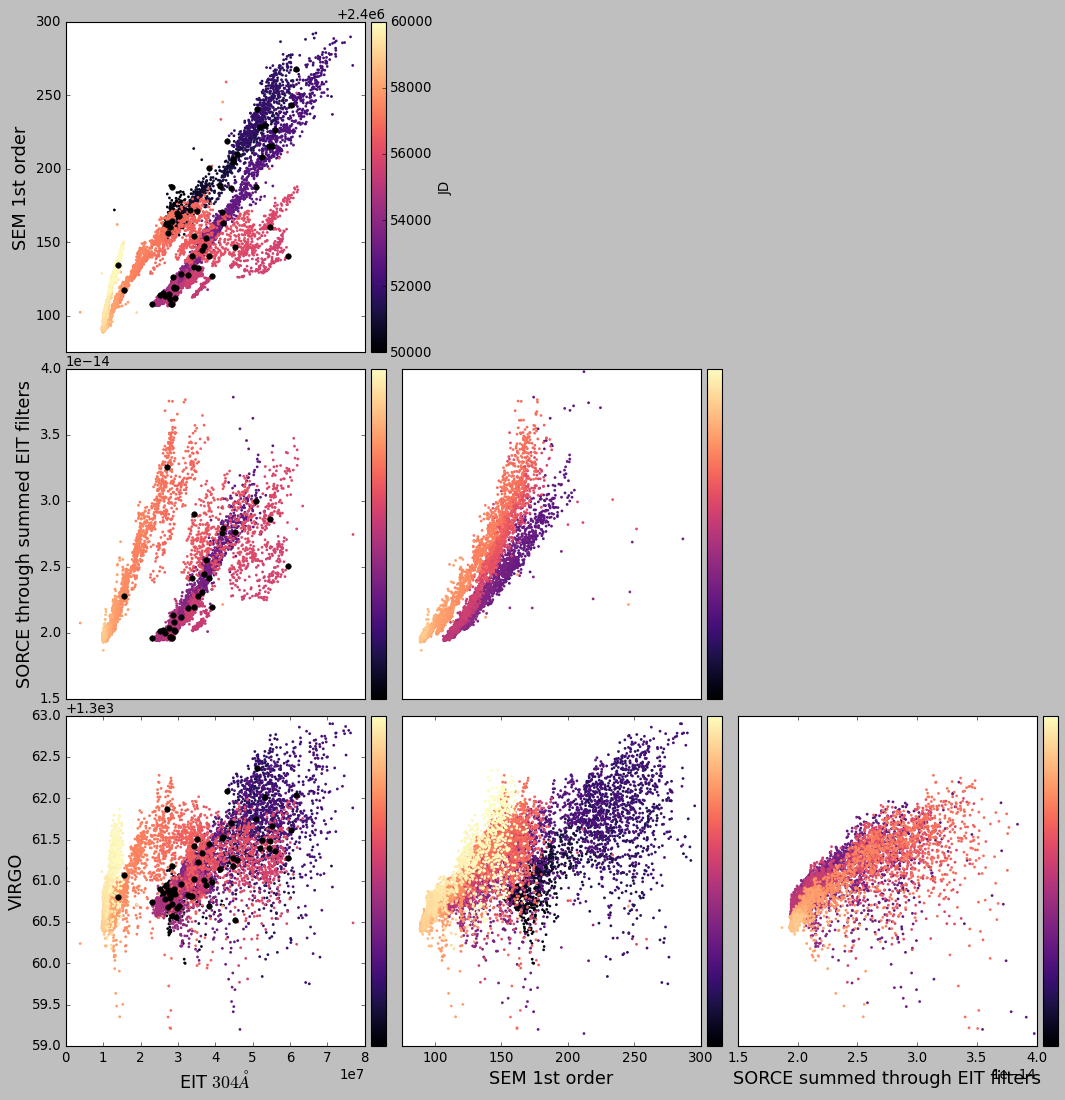

In [16]:
fig, axes = plt.subplots(3,3,figsize=(16,16))

#axes[0,0]: SEM 1st order vs EIT 304\AA
overlap_t, t304_ind, tSEM_ind = np.intersect1d(np.round(t304,0), np.round(tSEM,0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_t304_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(t304[t304_ind],0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_tSEM_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(tSEM[tSEM_ind],0), return_indices=True)

cs00 = axes[0,0].scatter(f304[t304_ind], fSEM[tSEM_ind], c=t304[t304_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)
axes[0,0].plot(f304[t304_ind][bk_t304_ind], fSEM[tSEM_ind][bk_tSEM_ind],ls='None', marker='.',ms=10,color='k')

divider = make_axes_locatable(axes[0,0])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
fig.colorbar(cs00, cax=cax,label="JD")

#axes[0,0].set_xlabel(r"EIT $304\AA$")
axes[0,0].set_ylabel(r"SEM 1st order",fontsize=16)
axes[0,0].set_xlim(0.,8.e7)
axes[0,0].set_ylim(75.,300)


#axes[1,0]: SORCE "total" UV LC vs EIT 304\AA
overlap_t, t304_ind, tSORCE_ind = np.intersect1d(np.round(t304,0), np.round(tSORCE,0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_t304_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(t304[t304_ind],0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_tSORCE_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(tSORCE[tSORCE_ind],0), return_indices=True)

cs10 = axes[1,0].scatter(f304[t304_ind], fSORCE[tSORCE_ind], c=t304[t304_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)
axes[1,0].plot(f304[t304_ind][bk_t304_ind], fSORCE[tSORCE_ind][bk_tSORCE_ind], ls='None', marker='.',ms=10,color='k')

divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
cbar = fig.colorbar(cs10, cax=cax)#,label="JD")
cbar.set_ticks([])

#axes[1,0].set_xlabel(r"EIT $304\AA$")
axes[1,0].set_ylabel(r"SORCE through summed EIT filters",fontsize=16)
axes[1,0].set_xlim(0.,8.e7)
axes[1,0].set_ylim(1.5e-14,4.0e-14)


#axes[2,0]: VIRGO vs EIT 304\AA
overlap_t, t304_ind, tVIRGO_ind = np.intersect1d(np.round(t304,0), np.round(tVIRGO,0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_t304_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(t304[t304_ind],0), return_indices=True)
bk_overlap_t, bk_bk_ind, bk_tVIRGO_ind = np.intersect1d(np.round(heaterOn['jd'],0), np.round(tVIRGO[tVIRGO_ind],0), return_indices=True)

cs20 = axes[2,0].scatter(f304[t304_ind], fVIRGO[tVIRGO_ind], c=t304[t304_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)
axes[2,0].plot(f304[t304_ind][bk_t304_ind], fVIRGO[tVIRGO_ind][bk_tVIRGO_ind], ls='None', marker='.',ms=10,color='k')

divider = make_axes_locatable(axes[2,0])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
cbar = fig.colorbar(cs20, cax=cax)#,label="JD")
cbar.set_ticks([])

axes[2,0].set_xlabel(r"EIT $304\AA$",fontsize=16)
axes[2,0].set_ylabel(r"VIRGO",fontsize=16)
axes[2,0].set_xlim(0.,8.e7)
axes[2,0].set_ylim(1359,1363)


#axes[1,1]: SORCE "total" UV LC vs SEM 1st order
overlap_t, tSEM_ind, tSORCE_ind = np.intersect1d(np.round(tSEM,0), np.round(tSORCE,0), return_indices=True)

cs11 = axes[1,1].scatter(fSEM[tSEM_ind], fSORCE[tSORCE_ind], c=tSEM[tSEM_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)

divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
cbar = fig.colorbar(cs11, cax=cax)#,label="JD")
cbar.set_ticks([])

#axes[1,1].set_xlabel(r"SEM 1st order")
#axes[1,1].set_ylabel(r"SORCE through summed EIT filters")
axes[1,1].set_xlim(75.,300)
axes[1,1].set_ylim(1.5e-14,4.0e-14)

#axes[2,1]: VIRGO vs SEM 1st order
overlap_t, tSEM_ind, tVIRGO_ind = np.intersect1d(np.round(tSEM,0), np.round(tVIRGO,0), return_indices=True)

cs21 = axes[2,1].scatter(fSEM[tSEM_ind], fVIRGO[tVIRGO_ind], c=tSEM[tSEM_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)

divider = make_axes_locatable(axes[2,1])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
cbar = fig.colorbar(cs21, cax=cax)#,label="JD")
cbar.set_ticks([])

axes[2,1].set_xlabel(r"SEM 1st order",fontsize=16)
#axes[2,1].set_ylabel(r"VIRGO")
axes[2,1].set_xlim(75.,300)
axes[2,1].set_ylim(1359,1363)

#axes[2,2]: VIRGO vs SORCE "total" UV LC
overlap_t, tSORCE_ind, tVIRGO_ind = np.intersect1d(np.round(tSORCE,0), np.round(tVIRGO,0), return_indices=True)

cs22 = axes[2,2].scatter(fSORCE[tSORCE_ind], fVIRGO[tVIRGO_ind], c=tSORCE[tSORCE_ind],marker='.', s=25, edgecolor='None', cmap='magma',vmin=2450000,vmax=2460000)

divider = make_axes_locatable(axes[2,2])
cax = divider.append_axes("right", size="5%", pad="2%")
fig.add_axes(cax)
cbar = fig.colorbar(cs22, cax=cax)#,label="JD")
cbar.set_ticks([])

axes[2,2].set_xlabel(r"SORCE summed through EIT filters",fontsize=16)
#axes[2,2].set_ylabel(r"VIRGO")
axes[2,2].set_xlim(1.5e-14,4.0e-14)
axes[2,2].set_ylim(1359,1363)



for ax in [axes[0,1], axes[0,2], axes[1,2]]:
    ax.axis("off")

for ax in [axes[0,0], axes[1,0], axes[1,1]]:
    ax.set_xticks([])
for ax in [axes[1,1], axes[2,1], axes[2,2]]:
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.05,wspace=0.05)

#plt.show()
plt.savefig("cornerPlot_EIT304_SEM1stOrder_SORCE_VIRGO.pdf",bbox_inches="tight")

## Ratio of EIT bands to SEM

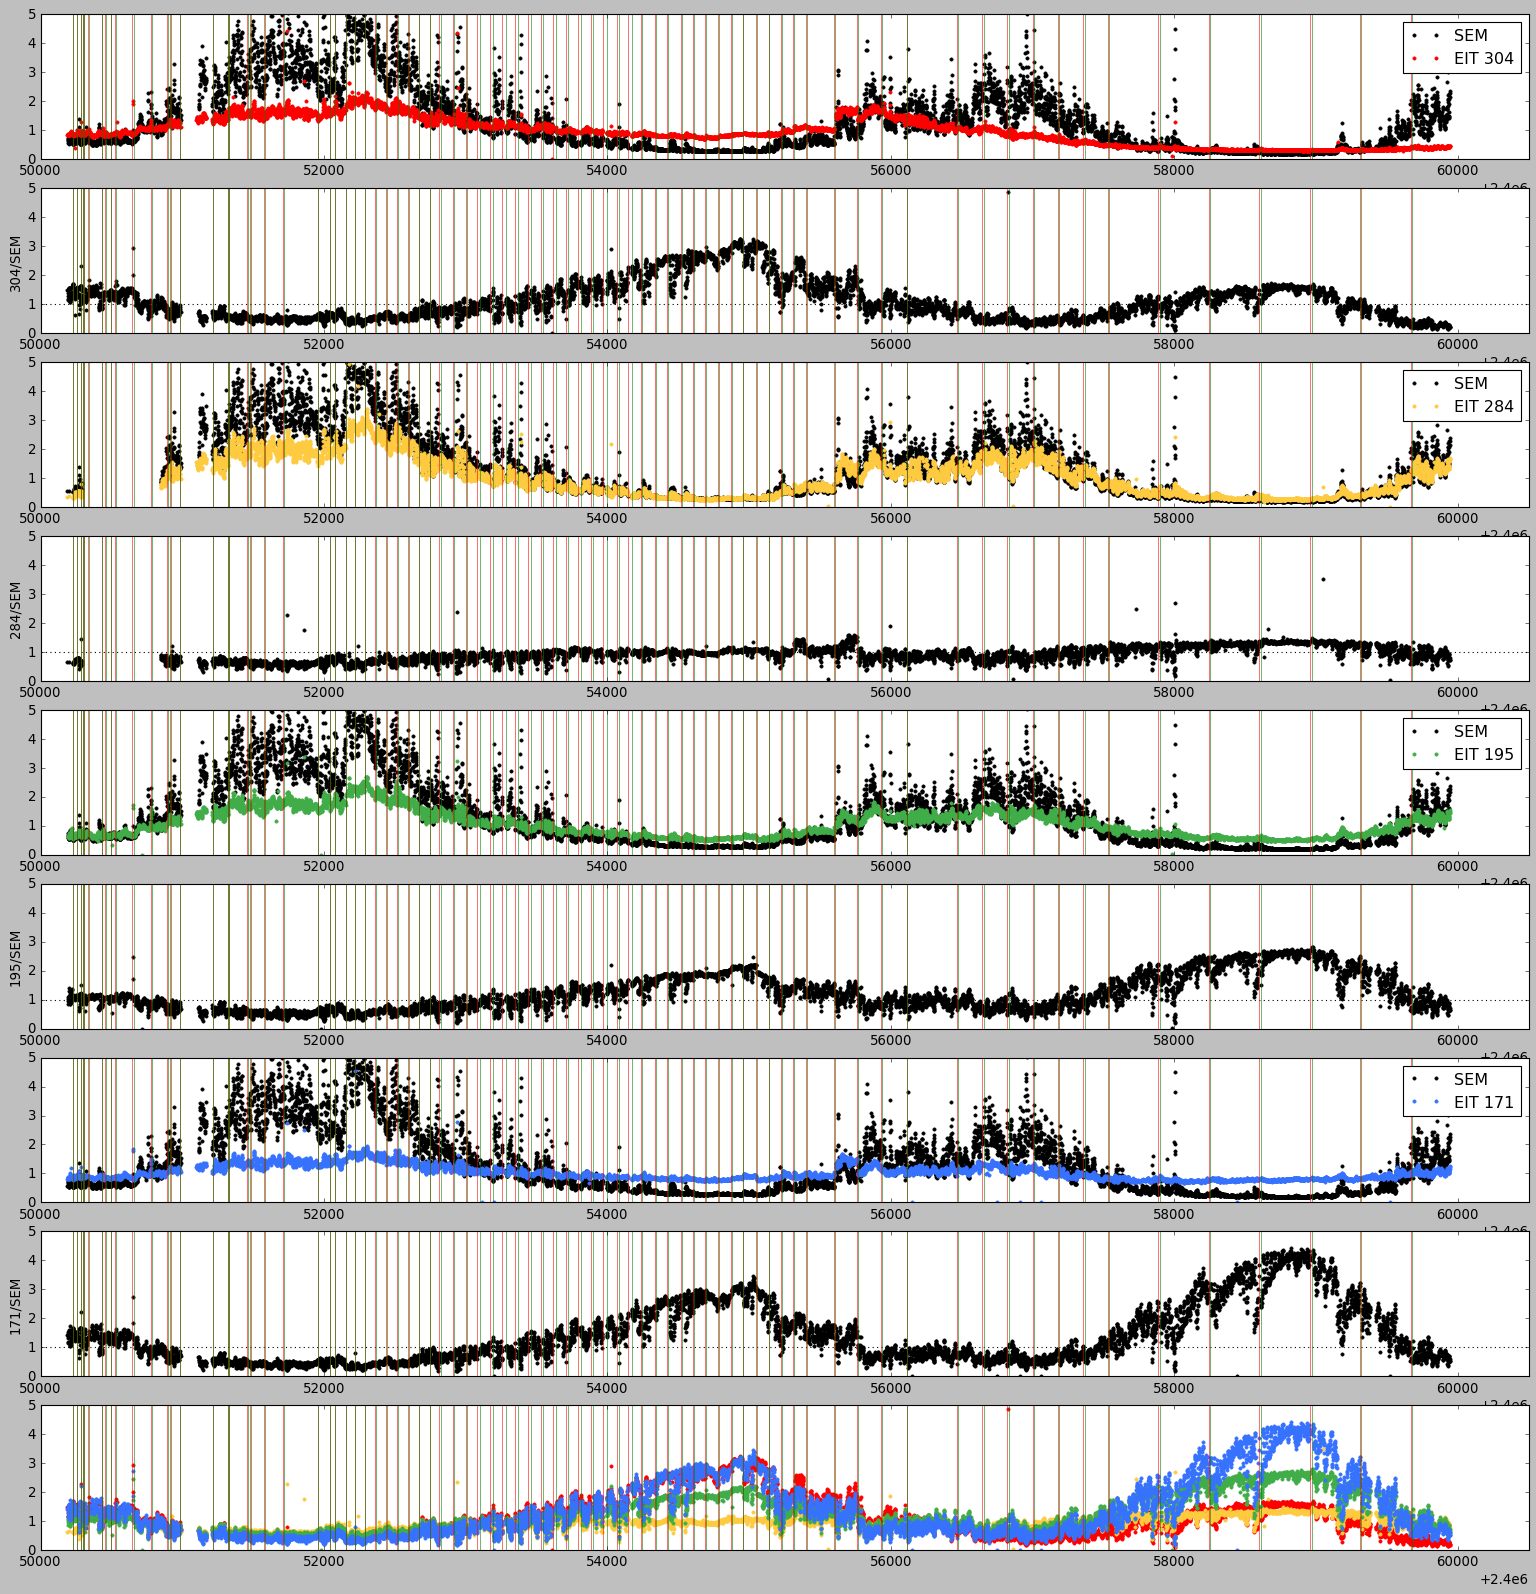

In [17]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, tSEM_ind = np.intersect1d(np.round(tEIT,0), np.round(tSEM,0), return_indices=True)
    axes[2*i].plot(tSEM[tSEM_ind], fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)]), 'k.',label='SEM')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),'k.')
    axes[2*i+1].set_ylim(0.,2.)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel('{0}/SEM'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSEM[tSEM_ind]/np.median(fSEM[~np.isnan(fSEM)])),marker='.',ls='None',color=cs[i])
    axes[8].set_ylim(0.,2.)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

#plt.show()
plt.savefig("./ratio_EITbands_to_SEM1stOrder.pdf",bbox_inches="tight")

## Ratio of EIT bands to SORCE

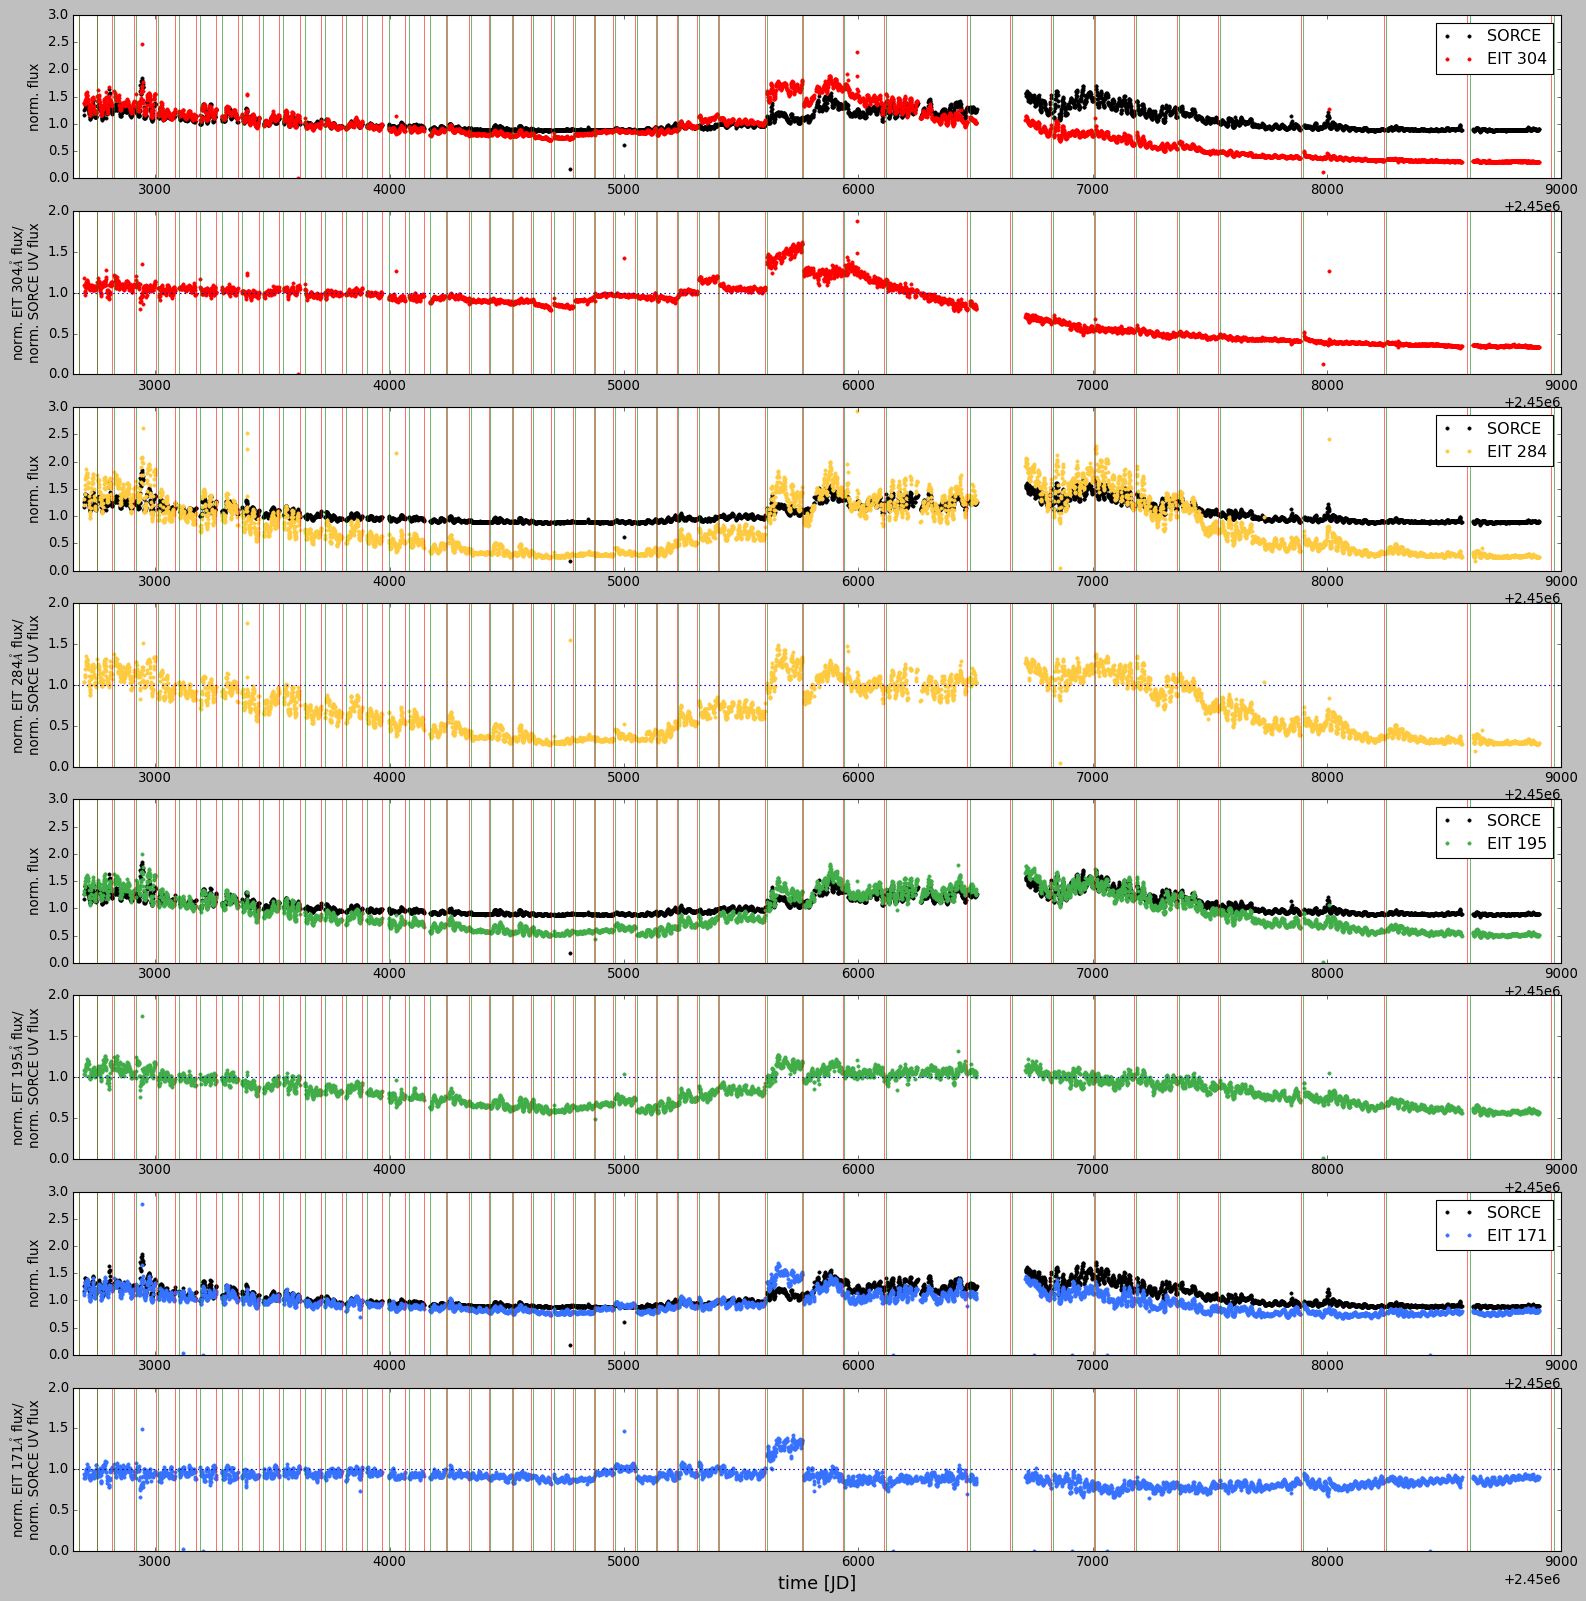

In [18]:
fig, axes = plt.subplots(8,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, tSORCE_ind = np.intersect1d(np.round(tEIT,0), np.round(tSORCE,0), return_indices=True)
    axes[2*i].plot(tSORCE[tSORCE_ind], fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)]), 'k.',label='SORCE')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.)
    axes[2*i].legend(loc='upper right')
    axes[2*i].set_ylabel('norm. flux')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])),marker='.',color=cs[i],ls='None')
    axes[2*i+1].set_ylim(0.,2.)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel(r'norm. EIT {0}$\AA$ flux/'.format(labels[i])+'\n'+'norm. SORCE UV flux')
    axes[2*i+1].axhline(1,ls=":")

    #axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fSORCE[tSORCE_ind]/np.median(fSORCE[~np.isnan(fSORCE)])),ls='None' ,marker='.',color=cs[i])
    #axes[8].set_ylim(0.,2.)
    

for ax in axes:
    ax.set_xlim(2452650,2459000)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    #ax.axvline(2454832.5000000,color='y',lw=2)
axes[7].set_xlabel("time [JD]",fontsize=16)
#plt.show()
plt.savefig("./ratio_EITbands_to_SORCE.pdf",bbox_inches="tight")

## ratio of EIT bands to VIRGO

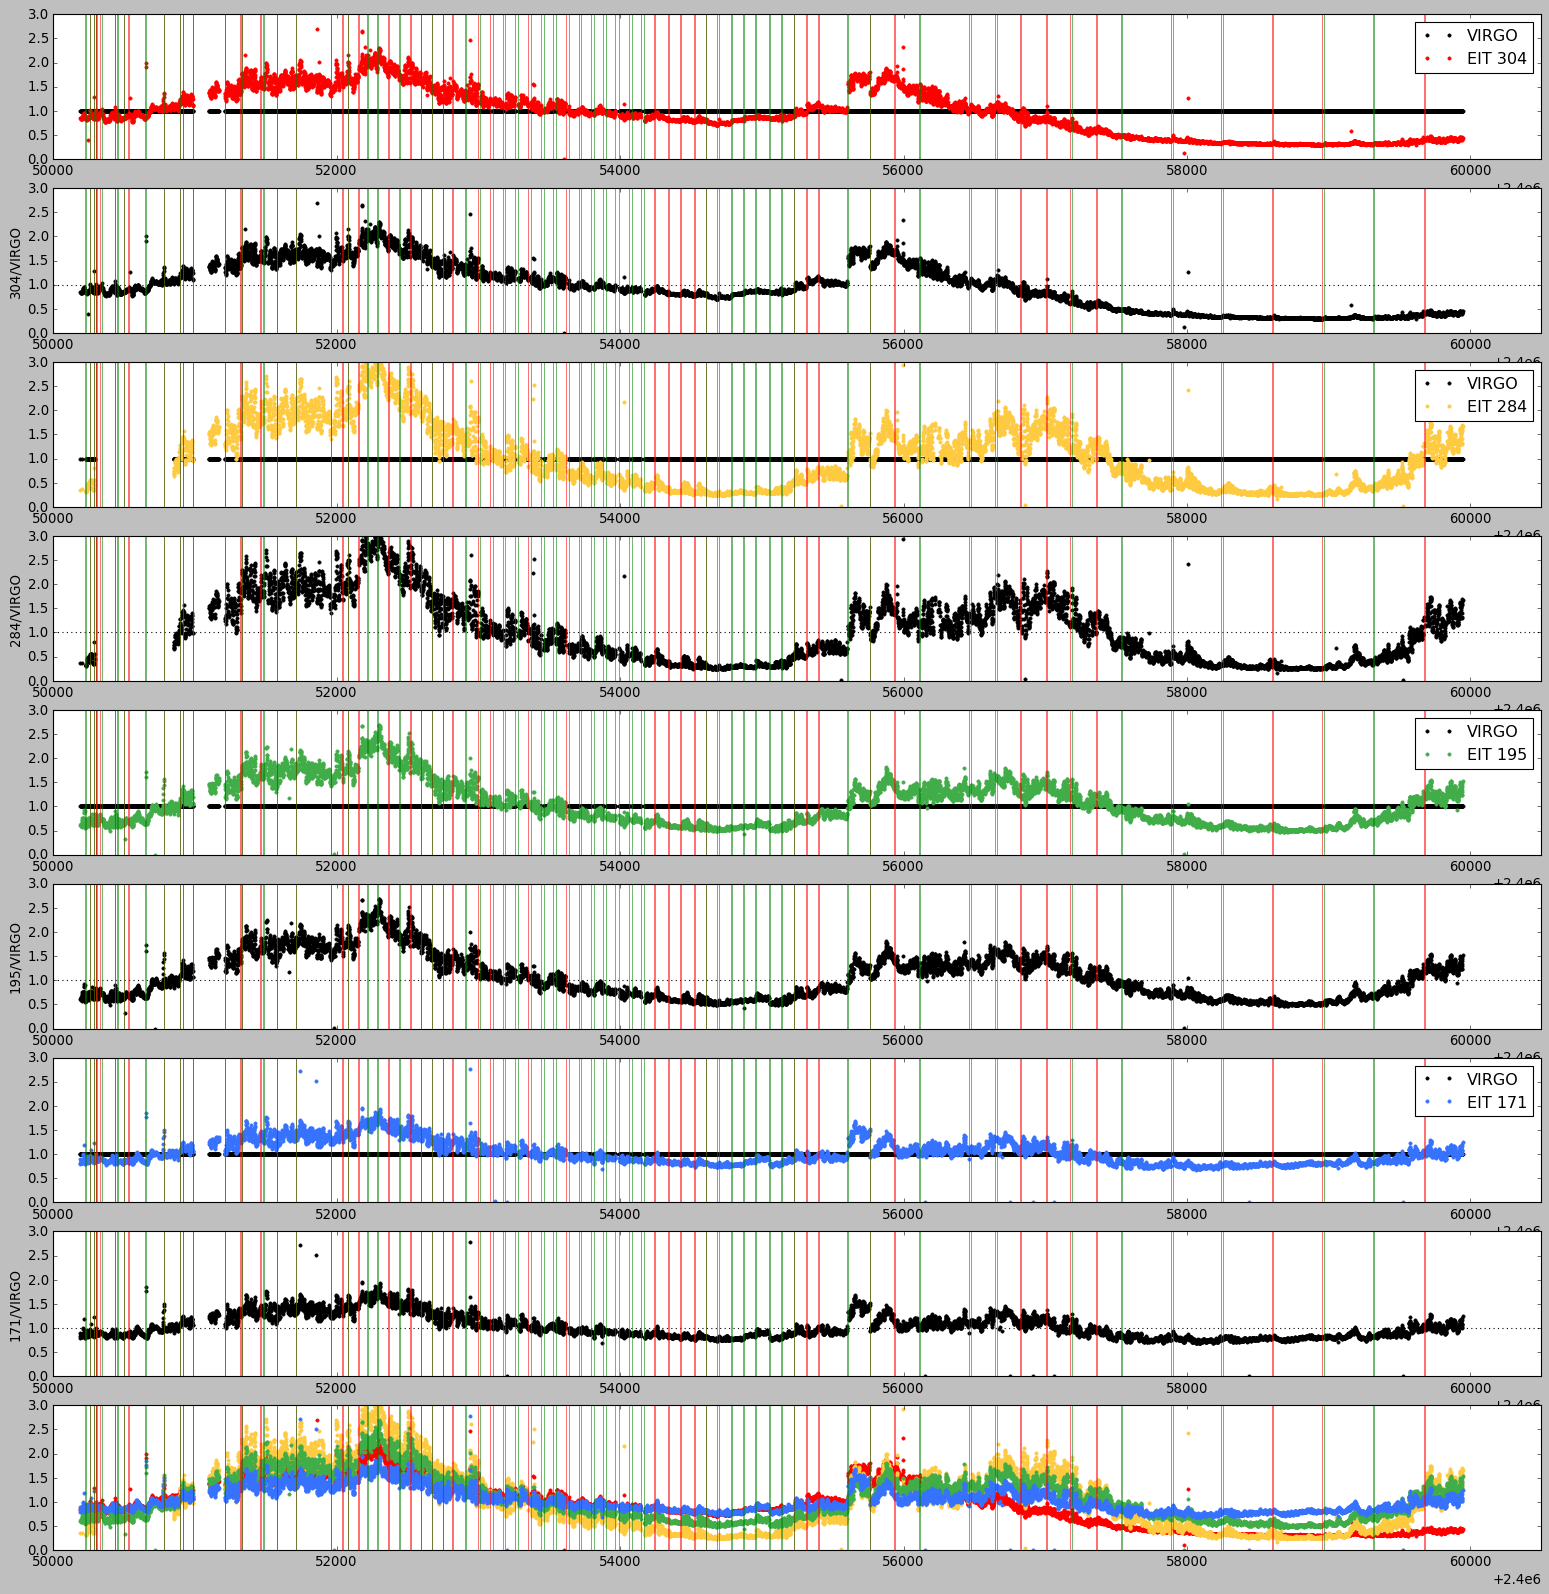

In [19]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, tVIRGO_ind = np.intersect1d(np.round(tEIT,0), np.round(tVIRGO,0), return_indices=True)
    axes[2*i].plot(tVIRGO[tVIRGO_ind], fVIRGO[tVIRGO_ind]/np.median(fVIRGO[~np.isnan(fVIRGO)]), 'k.',label='VIRGO')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fVIRGO[tVIRGO_ind]/np.median(fVIRGO[~np.isnan(fVIRGO)])),'k.')
    axes[2*i+1].set_ylim(0.,3.)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel('{0}/VIRGO'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(fVIRGO[tVIRGO_ind]/np.median(fVIRGO[~np.isnan(fVIRGO)])),ls='None' ,marker='.',color=cs[i])
    axes[8].set_ylim(0.,3.)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)

#plt.show()
plt.savefig("./ratio_EITbands_to_VIRGO.pdf",bbox_inches="tight")

# Ratio of EIT bands to each other (have somehow never looked at this?)

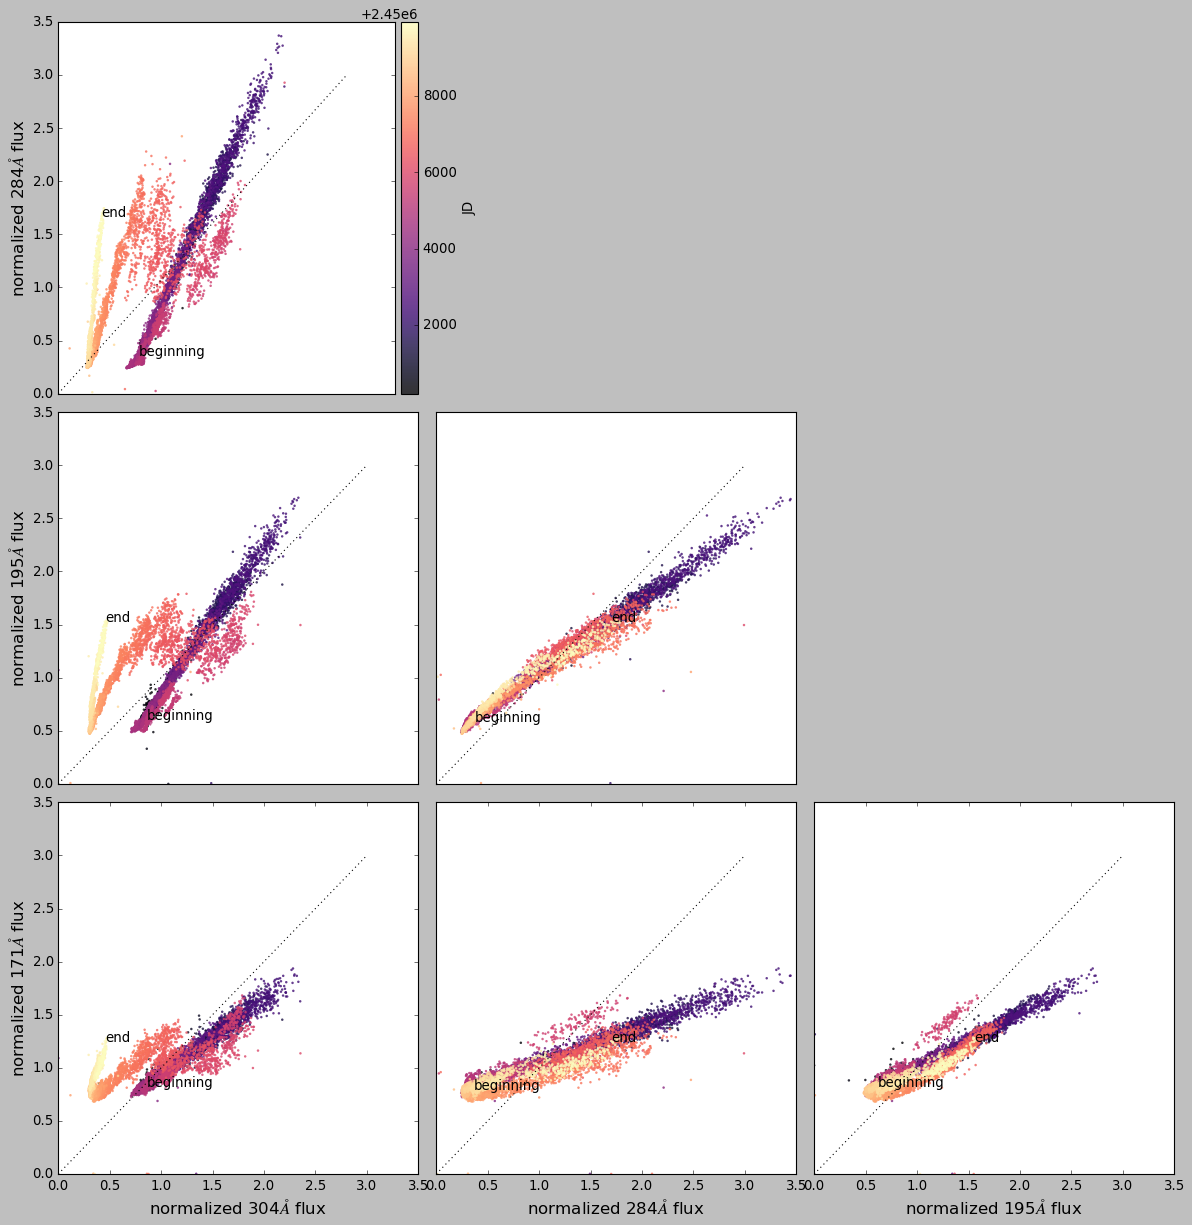

In [20]:
fig, axes = plt.subplots(3,3,figsize=(18,18))

for i in range(1,4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t304_ind = np.intersect1d(np.round(tEIT,0), np.round(t304,0), return_indices=True)

    c_s = axes[i-1,0].scatter(f304[t304_ind]/np.median(f304[~np.isnan(f304)]), fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]), c=t304[t304_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)
    axes[i-1,0].text(f304[t304_ind][0]/np.median(f304[~np.isnan(f304)]), fEIT[tEIT_ind][0]/np.median(fEIT[~np.isnan(fEIT)]), 'beginning')
    axes[i-1,0].text(f304[t304_ind][-1]/np.median(f304[~np.isnan(f304)]), fEIT[tEIT_ind][-1]/np.median(fEIT[~np.isnan(fEIT)]), 'end')
    
    axes[i-1,0].set_xlim(0,3.5)
    axes[i-1,0].set_ylim(0,3.5)

    if i==1:
        divider = make_axes_locatable(axes[0,0])
        cax = divider.append_axes("right", size="5%", pad="2%")
        fig.add_axes(cax)
        cbar = fig.colorbar(c_s, cax=cax,label="JD")
        #cbar.set_ticks([])


axes[2,0].set_xlabel(r"normalized 304$\AA$ flux",fontsize=15)
axes[0,0].set_ylabel(r"normalized 284$\AA$ flux",fontsize=15)
axes[1,0].set_ylabel(r"normalized 195$\AA$ flux",fontsize=15)
axes[2,0].set_ylabel(r"normalized 171$\AA$ flux",fontsize=15)


for i in range(2,4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t284_ind = np.intersect1d(np.round(tEIT,0), np.round(t284,0), return_indices=True)

    axes[i-1,1].scatter(f284[t284_ind]/np.median(f284[~np.isnan(f284)]), fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]), c=t284[t284_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)
    axes[i-1,1].text(f284[t284_ind][0]/np.median(f284[~np.isnan(f284)]), fEIT[tEIT_ind][0]/np.median(fEIT[~np.isnan(fEIT)]), 'beginning')
    axes[i-1,1].text(f284[t284_ind][-1]/np.median(f284[~np.isnan(f284)]), fEIT[tEIT_ind][-1]/np.median(fEIT[~np.isnan(fEIT)]), 'end')
    
    axes[i-1,1].set_xlim(0,3.5)
    axes[i-1,1].set_ylim(0,3.5)

axes[2,1].set_xlabel(r"normalized 284$\AA$ flux",fontsize=15)

#axes[1,1].set_ylabel("normalized 195 flux")
#axes[2,1].set_ylabel("normalized 171 flux")


for i in range(3,4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t195_ind = np.intersect1d(np.round(tEIT,0), np.round(t195,0), return_indices=True)

    axes[i-1,2].scatter(f195[t195_ind]/np.median(f195[~np.isnan(f195)]), fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]), c=t195[t195_ind],ls='None' ,marker='.',edgecolor='None',cmap='magma',label='EIT {0}'.format(labels[i]),alpha=0.8)
    axes[i-1,2].text(f195[t195_ind][0]/np.median(f195[~np.isnan(f195)]), fEIT[tEIT_ind][0]/np.median(fEIT[~np.isnan(fEIT)]),"beginning")
    axes[i-1,2].text(f195[t195_ind][-1]/np.median(f195[~np.isnan(f195)]), fEIT[tEIT_ind][-1]/np.median(fEIT[~np.isnan(fEIT)]),"end")    
    axes[i-1,2].set_xlim(0,3.5)
    axes[i-1,2].set_ylim(0,3.5)

axes[2,2].set_xlabel(r"normalized 195$\AA$ flux",fontsize=15)
#axes[2,2].set_ylabel("normalized 171 flux")


for ax in [axes[0,1],axes[0,2],axes[1,2]]:
    ax.axis("off")

for ax in [axes[0,0],axes[1,0],axes[1,1],axes[2,0],axes[2,1],axes[2,2]]:
    ax.plot(np.arange(4),np.arange(4),color='k',ls=':')

axes[0,0].set_xticks([])
axes[1,0].set_xticks([])
axes[1,1].set_xticks([])

axes[1,1].set_yticks([])
axes[2,1].set_yticks([])
axes[2,2].set_yticks([])
#plt.show()
plt.subplots_adjust(hspace=0.05,wspace=0.05)

plt.savefig("./ratio_EITbands_to_eachother.pdf",bbox_inches="tight")

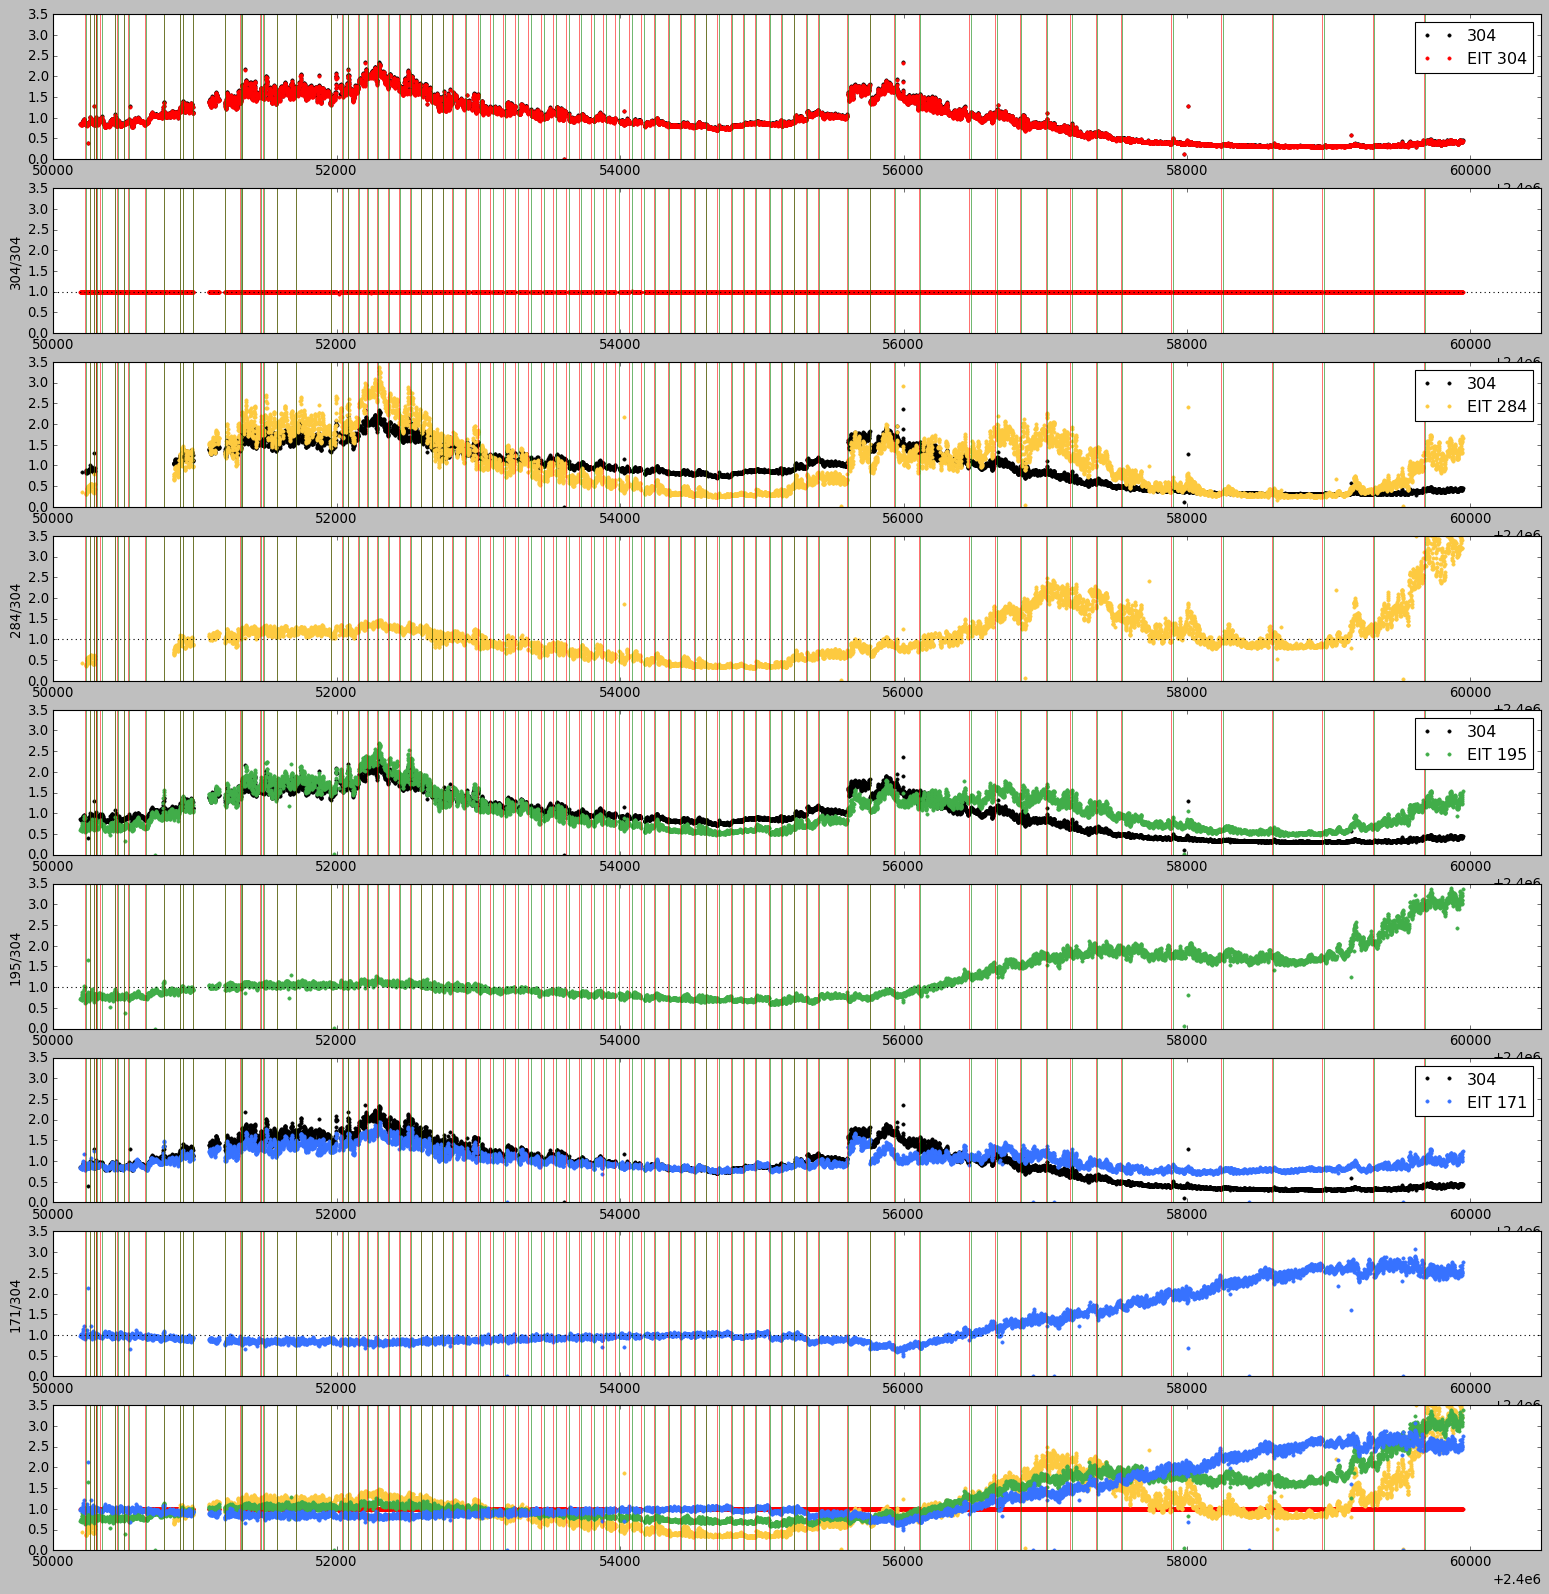

In [21]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t304_ind = np.intersect1d(np.round(tEIT,0), np.round(t304,0), return_indices=True)
    axes[2*i].plot(t304[t304_ind], f304[t304_ind]/np.median(f304[~np.isnan(f304)]), 'k.',label='304')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.5)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f304[t304_ind]/np.median(f304[~np.isnan(f304)])),ls='None' ,marker='.',color=cs[i])
    axes[2*i+1].set_ylim(0.,3.5)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel('{0}/304'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f304[t304_ind]/np.median(f304[~np.isnan(f304)])),marker='.',ls='None',color=cs[i])
    axes[8].set_ylim(0.,3.5)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

#plt.show()
plt.savefig("./ratio_EITbands_to_EIT304.pdf",bbox_inches="tight")

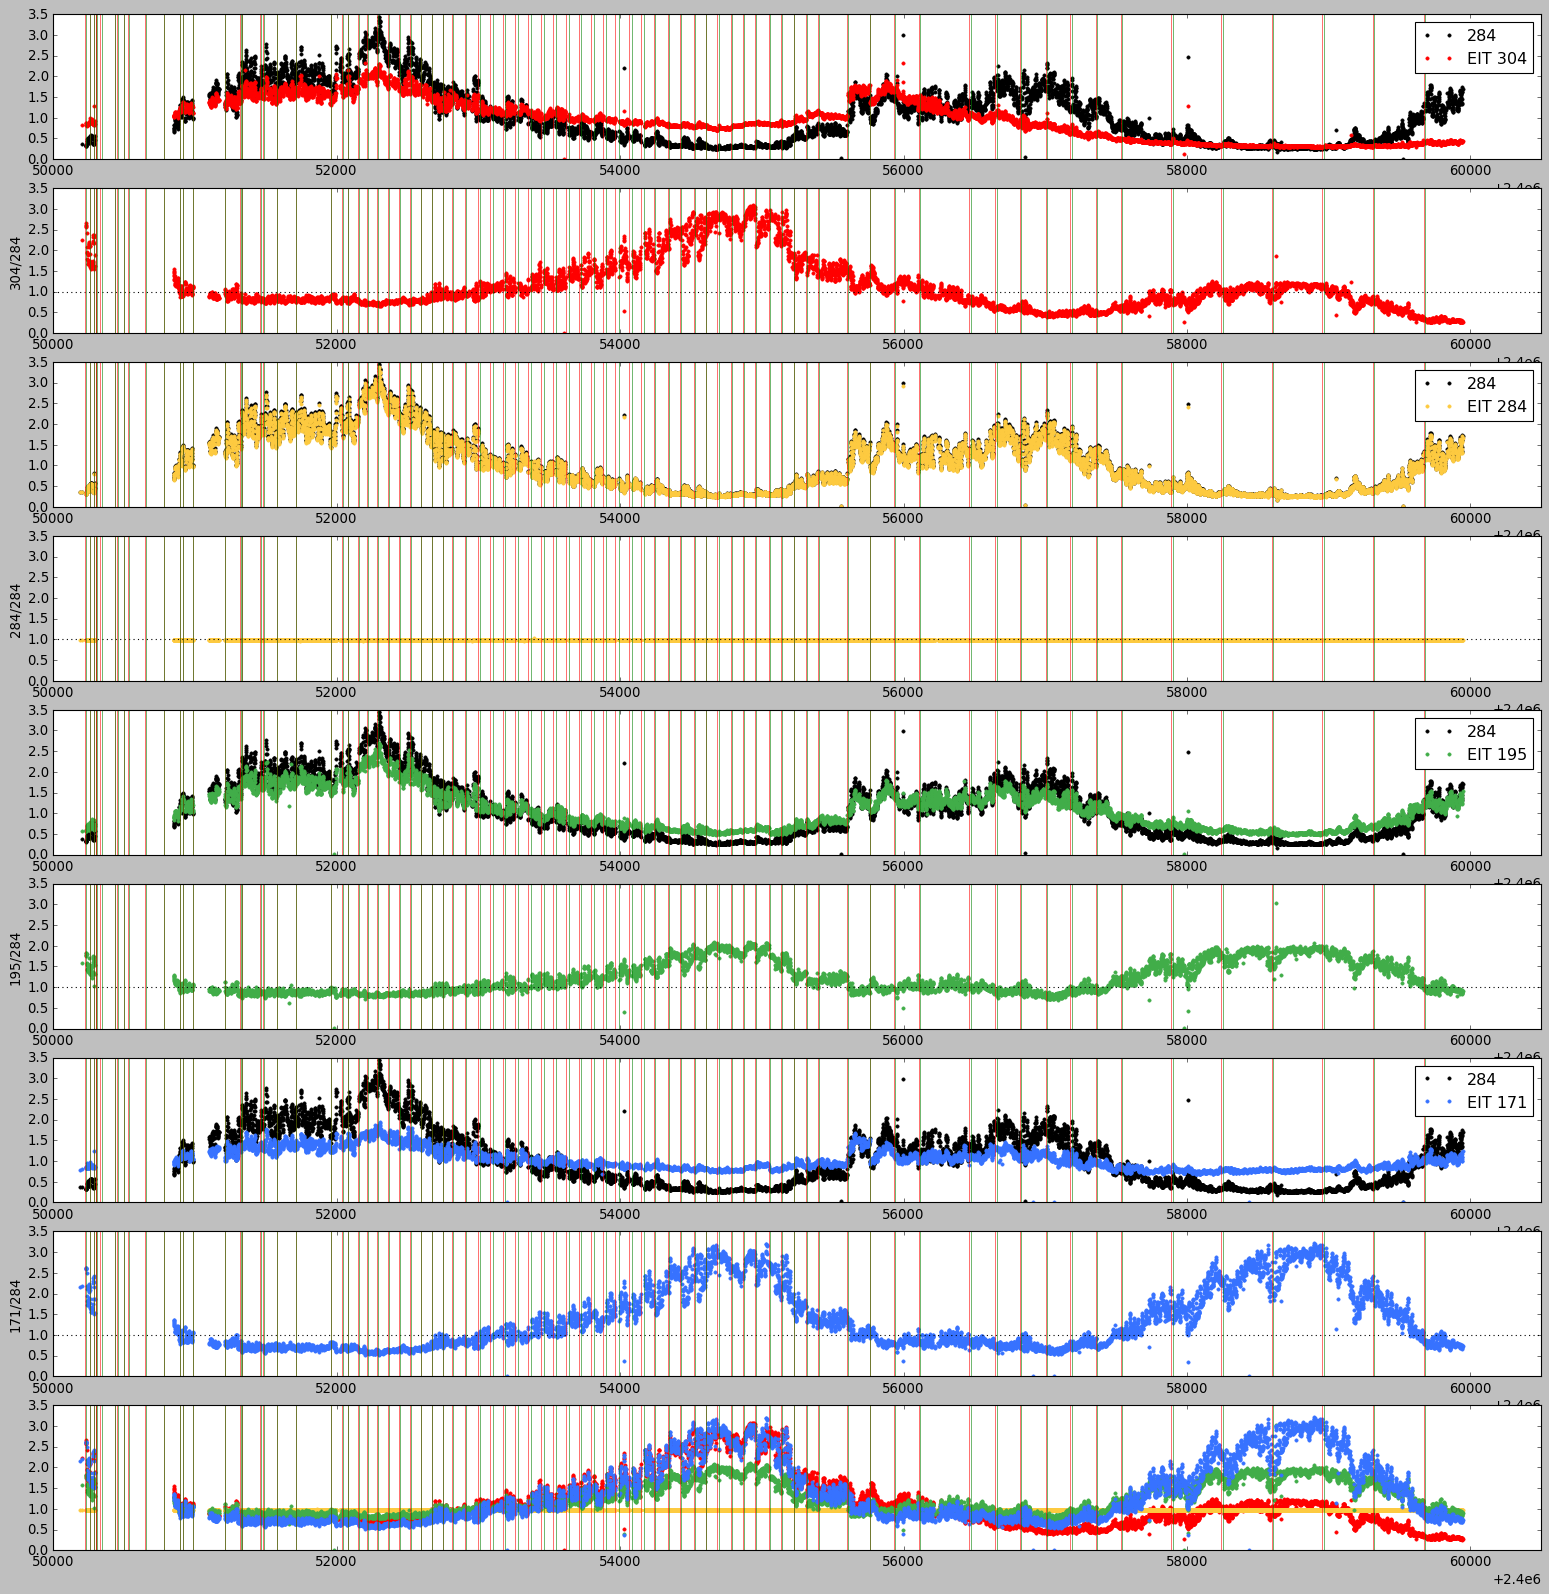

In [22]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t284_ind = np.intersect1d(np.round(tEIT,0), np.round(t284,0), return_indices=True)
    axes[2*i].plot(t284[t284_ind], f284[t284_ind]/np.median(f284[~np.isnan(f284)]), 'k.',label='284')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.5)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f284[t284_ind]/np.median(f284[~np.isnan(f284)])),ls='None' ,marker='.',color=cs[i])
    axes[2*i+1].set_ylim(0.,3.5)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel('{0}/284'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f284[t284_ind]/np.median(f284[~np.isnan(f284)])),marker='.',ls='None',color=cs[i])
    axes[8].set_ylim(0.,3.5)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

#plt.show()
plt.savefig("./ratio_EITbands_to_EIT284.pdf",bbox_inches="tight")

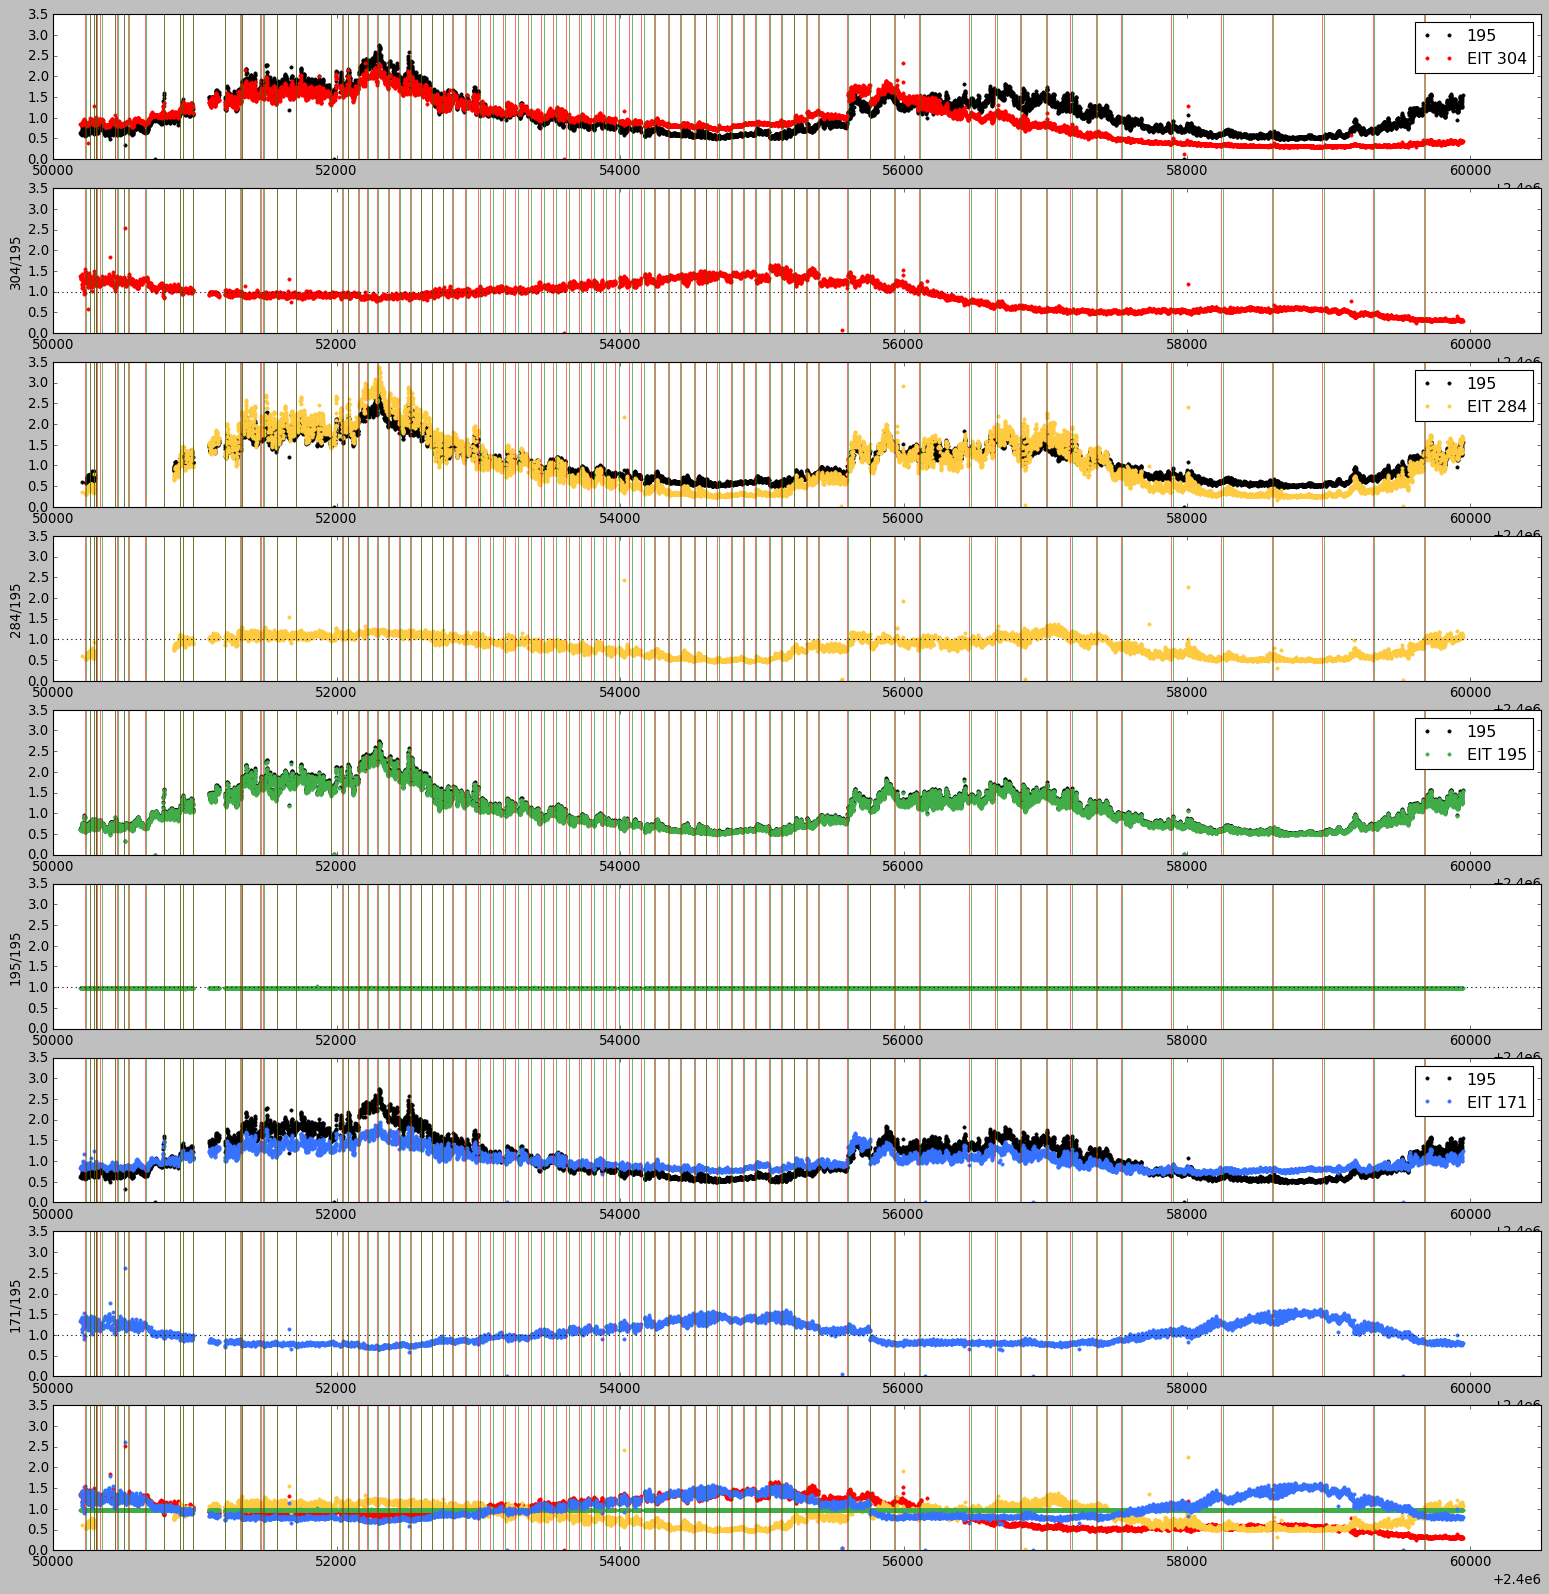

In [23]:
fig, axes = plt.subplots(9,1,figsize=(24,24))

for i in range(4):
    wmask_ = wmasks[i] & noPinholes
    tEIT = ts[wmask_]
    fEIT = fs[wmask_]

    overlap_t, tEIT_ind, t195_ind = np.intersect1d(np.round(tEIT,0), np.round(t195,0), return_indices=True)
    axes[2*i].plot(t195[t195_ind], f195[t195_ind]/np.median(f195[~np.isnan(f195)]), 'k.',label='195')
    axes[2*i].plot(tEIT[tEIT_ind], fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]),ls='None' ,marker='.',color=cs[i],label='EIT {0}'.format(labels[i]))
    axes[2*i].set_ylim(0.,3.5)
    axes[2*i].legend(loc='upper right')

    axes[2*i+1].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f195[t195_ind]/np.median(f195[~np.isnan(f195)])),ls='None' ,marker='.',color=cs[i])
    axes[2*i+1].set_ylim(0.,3.5)
    axes[2*i+1].axhline(1.0,linestyle=":",color='k')
    axes[2*i+1].set_ylabel('{0}/195'.format(labels[i]))

    axes[8].plot(tEIT[tEIT_ind], (fEIT[tEIT_ind]/np.median(fEIT[~np.isnan(fEIT)]))/(f195[t195_ind]/np.median(f195[~np.isnan(f195)])),marker='.',ls='None',color=cs[i])
    axes[8].set_ylim(0.,3.5)
    

for ax in axes:
    ax.set_xlim(2450000,2460500)
    for i in range(81):
        bakeoutStartDate = heaterOn[i]['jd']
        bakeoutEndDate = heaterOff[i]['jd']

        ax.axvline(bakeoutStartDate,color='r',linestyle='-',lw=0.5)
        ax.axvline(bakeoutEndDate,color='g',linestyle='-',lw=0.5)
    # date of biggest problematic bakeout (11 Feb 2011)
    #ax.axvline(2455602.208, color='y', lw=3)
    #date of big SOHO pointing adjustment (22 Sept 2010)
    #ax.axvline(2455462.239114713, color='y', lw=3)

#plt.show()
plt.savefig("./ratio_EITbands_to_EIT195.pdf",bbox_inches="tight")